In [1]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
import json
from tqdm import tqdm_notebook, tqdm
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from slugify import slugify

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

%reload_ext autoreload
%autoreload 2
    
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.14.2
Thu May 09 12:03:23 2019 PDT

In [2]:
from google.cloud import bigquery

In [3]:
from dotenv import load_dotenv
load_dotenv('../../.env')

True

In [4]:
client = bigquery.Client()

# Page Paths
Alex's development notebook for page paths.

## Read data

### Read precomputed local file

In [5]:
def load_file(f_path):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    df = pd.read_csv(f_path)
    df.date = pd.to_datetime(df.date)
    return df

df_long = load_file('../../data/interim/page_paths_raw.csv')

Loading ../../data/interim/page_paths_raw.csv


In [6]:
df_long.head()

,id,date,isMobile,transactions,numHits,hitNumber,pagePath,pageTitle
0,1,2016-08-01,False,NaN,3,1,/home,Home
1,1,2016-08-01,False,NaN,3,2,/google+redesign/gift+cards,Gift Cards
2,1,2016-08-01,False,NaN,3,3,/signin.html,The Google Merchandise Store - Log In
3,2,2016-08-01,False,NaN,3,1,/home,Home
4,2,2016-08-01,False,NaN,3,2,/google+redesign/apparel/men++s/men++s+t+shirts,Men's-T-Shirts


In [7]:
# df['week'] = df.date.apply(lambda x: x.strftime('%W'))
# df['year'] = df.date.apply(lambda x: x.strftime('%Y'))
# df['week_start'] = df[['week', 'year']].apply(
#     lambda x: datetime.datetime.strptime('{}-{}-1'.format(x.year, x.week), '%Y-%W-%w'),
#     axis=1
# )

In [8]:
df_long.dtypes

id                       int64
date            datetime64[ns]
isMobile                  bool
transactions           float64
numHits                  int64
hitNumber                int64
pagePath                object
pageTitle               object
dtype: object

### Build session aggregate dataframe

In [9]:
CELL_TRIGGER = True

def make_session_agg_df(df) -> pd.DataFrame:
    df_ = df.copy()
    df_.transactions = df_.transactions.fillna(0)

    data = []
    cols = ['id', 'date', 'is_mobile', 'transactions', 'num_hits',
            'page_paths', 'page_titles']

    for id_ in tqdm_notebook(df_['id'].drop_duplicates().tolist()):
        m = df_['id'] == id_
        s = df_[m]
        data.append([
            id_,
            s.date.iloc[0],
            s.isMobile.iloc[0],
            s.transactions.sum(),
            s.numHits.iloc[0],
            s.pagePath.tolist(),
            s.pageTitle.tolist(),
        ])

    return pd.DataFrame(data, columns=cols)

if CELL_TRIGGER:
    df_sess = make_session_agg_df(df_long)
    df_sess.to_csv('../../data/interim/page_paths_sess_agg_raw.csv', index=False)
    df_sess.to_pickle('../../data/interim/page_paths_sess_agg_raw.pkl')

In [10]:
df_sess.head()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles
0,1,2016-08-01,False,0.0,3,"[/home, /google+redesign/gift+cards, /signin.h...","[Home, Gift Cards, The Google Merchandise Stor..."
1,2,2016-08-01,False,0.0,3,"[/home, /google+redesign/apparel/men++s/men++s...","[Home, Men's-T-Shirts, Office]"
2,3,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/apparel, /home]","[Home, Home, Apparel, Home]"
3,4,2016-08-01,False,0.0,4,"[/home, /google+redesign/apparel, /home, /home]","[Home, Apparel, Home, Home]"
4,5,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/bags/backpacks...","[Home, Home, Backpacks, Backpacks]"


In [11]:
df_sess.tail()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles
903648,903649,2017-08-01,True,0.0,11,"[/google+redesign/shop+by+brand/youtube, /goog...",[YouTube | Shop by Brand | Google Merchandise ...
903649,903650,2017-08-01,False,0.0,12,[/google+redesign/apparel/men+s+t+shirts/googl...,"[Google Toddler Short Sleeve Tee Red, Google T..."
903650,903651,2017-08-01,False,0.0,14,[/google+redesign/apparel/womens+performance+w...,[Women's Performance Wear | Apparel | Google M...
903651,903652,2017-08-01,False,0.0,14,"[/google+redesign/shop+by+brand/youtube, /goog...",[YouTube | Shop by Brand | Google Merchandise ...
903652,903653,2017-08-01,True,0.0,18,"[/google+redesign/shop+by+brand/youtube, /stor...",[YouTube | Shop by Brand | Google Merchandise ...


In [12]:
df_sess.dtypes

id                       int64
date            datetime64[ns]
is_mobile                 bool
transactions           float64
num_hits                 int64
page_paths              object
page_titles             object
dtype: object

### Load session aggregate dataframe

In [13]:
CELL_TRIGGER = True

def load_file(f_path, load_pkl):
    if not os.path.exists(f_path):
        print('No data found. Run data load script above.')
        return
    print('Loading {}'.format(f_path))
    if load_pkl:
        df = pd.read_pickle(f_path)
    else:
        df = pd.read_csv(f_path)
        df.date = pd.to_datetime(df.date)
    return df

if CELL_TRIGGER:
    df_sess = load_file('../../data/interim/page_paths_sess_agg_raw.pkl', load_pkl=True)

Loading ../../data/interim/page_paths_sess_agg_raw.pkl


In [14]:
df_sess.head()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles
0,1,2016-08-01,False,0.0,3,"[/home, /google+redesign/gift+cards, /signin.h...","[Home, Gift Cards, The Google Merchandise Stor..."
1,2,2016-08-01,False,0.0,3,"[/home, /google+redesign/apparel/men++s/men++s...","[Home, Men's-T-Shirts, Office]"
2,3,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/apparel, /home]","[Home, Home, Apparel, Home]"
3,4,2016-08-01,False,0.0,4,"[/home, /google+redesign/apparel, /home, /home]","[Home, Apparel, Home, Home]"
4,5,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/bags/backpacks...","[Home, Home, Backpacks, Backpacks]"


In [15]:
df_sess.tail()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles
903648,903649,2017-08-01,True,0.0,11,"[/google+redesign/shop+by+brand/youtube, /goog...",[YouTube | Shop by Brand | Google Merchandise ...
903649,903650,2017-08-01,False,0.0,12,[/google+redesign/apparel/men+s+t+shirts/googl...,"[Google Toddler Short Sleeve Tee Red, Google T..."
903650,903651,2017-08-01,False,0.0,14,[/google+redesign/apparel/womens+performance+w...,[Women's Performance Wear | Apparel | Google M...
903651,903652,2017-08-01,False,0.0,14,"[/google+redesign/shop+by+brand/youtube, /goog...",[YouTube | Shop by Brand | Google Merchandise ...
903652,903653,2017-08-01,True,0.0,18,"[/google+redesign/shop+by+brand/youtube, /stor...",[YouTube | Shop by Brand | Google Merchandise ...


In [16]:
df_sess.dtypes

id                       int64
date            datetime64[ns]
is_mobile                 bool
transactions           float64
num_hits                 int64
page_paths              object
page_titles             object
dtype: object

Fixing bug where page title is NaN for the homepage...

e.g.

In [33]:
df_sess.iloc[35915]

id                            35916
date            2016-08-15 00:00:00
is_mobile                     False
transactions                      0
num_hits                          2
page_paths           [/home, /home]
page_titles              [nan, nan]
Name: 35915, dtype: object

**NOTE: making a huge assumption here (that ever NaN is a homepage - might not be the case). Be more carful if running this in production.**

In [39]:
df_sess['page_titles'] = df_sess['page_titles'].apply(lambda seq: ['Home' if str(x) == 'nan' else x for x in seq])

## Data mining

In [17]:
from prefixspan import PrefixSpan
from sklearn.preprocessing import LabelEncoder

Setting up sequential pattern mining

In [154]:
import hashlib
hash_sha224 = lambda x: hashlib.sha224(x.encode('utf-8')).hexdigest()

def custom_filter(patt, matches=None):
    """
    Filter top sequence results, removing matches that
        - Have length 1
        - Have duplicate elements
        
    patt : list
        Sequential pattern e.g. [1, 2]
        
    matches : list
        Index and position of matches (not used).
        e.g. [(0, 1), (1, 0), (2, 1), (3, 0)]
    """
    patt_len = len(patt)
    if patt_len <= 1:
        return False
    elif len(set(patt)) != patt_len:
        return False
    return True


def callback(patt, matches, top_k, patt_indices, label_encoder):
    """
    Save index results using this callback
    
    patt, matches : lists
        Passed by PrefixSpan.topk
        
    top_k : list
        Store counts and page_labels
        
    patt_indices : dict
        Store training data indices for feature label keys

    """
    pattern = label_encoder.inverse_transform(patt)
    patt_id = hash_sha224('_'.join(pattern))
    patt_indices[patt_id] = [m[0] for m in matches]
    top_k.append([len(matches), pattern])


def get_topk_sequences(sequences, label_encoder, k, custom_filter, callback):
    labeled_sequences = [label_encoder.transform(seq) for seq in sequences]
    prefix_spans = PrefixSpan(labeled_sequences)
    patt_indices = {}
    top_k = []
    prefix_spans.topk(k, callback=lambda patt, matches: callback(patt, matches, top_k, patt_indices, label_encoder))
    
    out = []
    for count, page_labels in top_k:
        if custom_filter(page_labels):
            out.append([count, page_labels])

    return out, patt_indices

Setting up label encoders

In [20]:
page_paths = list(df_long.pagePath.unique())
page_path_le = LabelEncoder()
page_path_le.fit(page_paths)

page_titles = list(df_long.pageTitle.unique())
page_title_le = LabelEncoder()
page_title_le.fit(page_titles)

LabelEncoder()

Let's focus on page titles for now. Can loop back and look at page path later

In [42]:
# for i, seq in enumerate(sequences):
#     try:
#         page_title_le.transform(seq)
#     except Exception as e:
#         print(e)
#         print(i)
#         print(seq)

In [155]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [156]:
sequences = df_sess.page_titles.tolist()

topk_raw, topk_patt_indices_raw = get_topk_sequences(
    sequences,
    label_encoder=page_title_le,
    k=1000,
    custom_filter=custom_filter,
    callback=callback,
)

In [157]:
topk_raw[:50]

[[112529, array(['Google Online Store', 'Home'], dtype='<U576')],
 [49191, array(['Home', 'Shopping Cart'], dtype='<U576')],
 [43229,
  array(['Home', 'The Google Merchandise Store - Log In'], dtype='<U576')],
 [29552, array(['Home', "Men's T-Shirts | Apparel | Google Merchandise Store"],
        dtype='<U576')],
 [29058, array(['Home', 'Store search results'], dtype='<U576')],
 [28653, array(['Home', 'YouTube | Shop by Brand | Google Merchandise Store'],
        dtype='<U576')],
 [28580, array(['Shopping Cart', 'The Google Merchandise Store - Log In'],
        dtype='<U576')],
 [26441,
  array(['The Google Merchandise Store - Log In', 'Home'], dtype='<U576')],
 [26022, array(['Shopping Cart', 'Home'], dtype='<U576')],
 [23450, array(['The Google Merchandise Store - Log In', 'Shopping Cart'],
        dtype='<U576')],
 [22024, array(['Home', 'Google | Shop by Brand | Google Merchandise Store'],
        dtype='<U576')],
 [21795, array(['Shopping Cart', 'Checkout Your Information'], dtype

In [ ]:
print('Indeces for top patterns:')

patt_eg = topk_raw[0][1]
patt_id = hash_sha224('_'.join(patt_eg))
print(patt_eg)
print(topk_patt_indices_raw[patt_id])
print()

patt_eg = topk_raw[1][1]
patt_id = hash_sha224('_'.join(patt_eg))
print(patt_eg)
print(len(topk_patt_indices_raw[patt_id]))

Dump calculation to file

In [159]:
CELL_TRIGGER = True

if CELL_TRIGGER:
    
    # Save the topk paths
    with open('../../data/interim/path_paths_topk_1000_titles.jsonl', 'w') as f:
        for line in topk_raw:
            f.write('{}\n'.format(
                json.dumps({'count': line[0], 'pattern': list(line[1])})
            ))
            
    # Load the index lookup dict
    with open('../../data/interim/page_paths_topk_1000_titles_patt_indices.json', 'w') as f:
        f.write(json.dumps(topk_patt_indices_raw))

Add as wide-form (one hot encoded) features to `df_sess`

### Modling converting / non-converting sessions with page path features

#### Read in topk page paths

In [160]:
CELL_TRIGGER = True

if CELL_TRIGGER:
    
    # Load the topk paths
    topk = []
    with open('../../data/interim/path_paths_topk_1000_titles.jsonl', 'r') as f:
        topk = [json.loads(line) for line in f.read().splitlines() if line.strip()]
        
    # Load the index lookup dict
    with open('../../data/interim/page_paths_topk_1000_titles_patt_indices.json', 'r') as f:
        topk_patt_indices = json.loads(f.read())
    

In [161]:
print(json.dumps(topk_patt_indices, indent=4)[:500])

{
    "2e47266bf9b3637ee9d21682a81bd4ad6667d25d1e0946564654bc9b": [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        27,
        29,
        31,
        32,
        49,
        50,
        54,
        55,
        56,
        58,
        60,
        62


In [162]:
import hashlib
hash_sha224 = lambda x: hashlib.sha224(x.encode('utf-8')).hexdigest()

In [163]:
df_topk = pd.DataFrame(topk)
df_topk['pattern_str'] = df_topk.pattern.astype(str)
df_topk['pattern_hash'] = df_topk.pattern.apply(lambda x: hash_sha224('_'.join(x)))
df_topk.head()

,count,pattern,pattern_str,pattern_hash
0,112529,"[Google Online Store, Home]","['Google Online Store', 'Home']",8f4f0025fb85213867ead12d84ea2e5055c357f971f9c8...
1,49191,"[Home, Shopping Cart]","['Home', 'Shopping Cart']",60a83762c35819646db68cf17badede7a3aad8ef7aee74...
2,43229,"[Home, The Google Merchandise Store - Log In]","['Home', 'The Google Merchandise Store - Log In']",8da84501af62cb70f8ec1ef98f6f97fd350ed51b8d5465...
3,29552,"[Home, Men's T-Shirts | Apparel | Google Merch...","['Home', ""Men's T-Shirts | Apparel | Google Me...",2000276390f3a9f47fab5d4125e23af8fde0ff61ec08de...
4,29058,"[Home, Store search results]","['Home', 'Store search results']",7a23cd532f76e62ea1680c6ce9d39a66ddae1135c4ed41...


Add pattern ID to map indices

In [164]:
top_k_pattern_hashes = df_topk[['pattern_hash', 'pattern_str']].values.tolist()

In [165]:
top_k_pattern_hashes[:5]

[['8f4f0025fb85213867ead12d84ea2e5055c357f971f9c8e7f1adb756',
  "['Google Online Store', 'Home']"],
 ['60a83762c35819646db68cf17badede7a3aad8ef7aee74e92601e59f',
  "['Home', 'Shopping Cart']"],
 ['8da84501af62cb70f8ec1ef98f6f97fd350ed51b8d546561081af9fa',
  "['Home', 'The Google Merchandise Store - Log In']"],
 ['2000276390f3a9f47fab5d4125e23af8fde0ff61ec08dee32329174e',
  '[\'Home\', "Men\'s T-Shirts | Apparel | Google Merchandise Store"]'],
 ['7a23cd532f76e62ea1680c6ce9d39a66ddae1135c4ed410f00d33370',
  "['Home', 'Store search results']"]]

In [166]:
# dict(
#     list(topk_counts.items())[:10]
# )

Label training data

In [167]:
df_training = pd.read_pickle('../../data/interim/page_paths_sess_agg_raw.pkl')

In [168]:
df_training.head()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles
0,1,2016-08-01,False,0.0,3,"[/home, /google+redesign/gift+cards, /signin.h...","[Home, Gift Cards, The Google Merchandise Stor..."
1,2,2016-08-01,False,0.0,3,"[/home, /google+redesign/apparel/men++s/men++s...","[Home, Men's-T-Shirts, Office]"
2,3,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/apparel, /home]","[Home, Home, Apparel, Home]"
3,4,2016-08-01,False,0.0,4,"[/home, /google+redesign/apparel, /home, /home]","[Home, Apparel, Home, Home]"
4,5,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/bags/backpacks...","[Home, Home, Backpacks, Backpacks]"


Fill NaN page_paths with `Home`.

**NOTE: making a huge assumption here (that ever NaN is a homepage - might not be the case). Be more carful if running this in production.**

In [169]:
df_training['page_titles_nan_fill'] = df_training['page_titles'].apply(
    lambda seq: ['Home' if str(x) == 'nan' else x for x in seq]
)

In [170]:
import hashlib
hash_sha224 = lambda x: hashlib.sha224(x.encode('utf-8')).hexdigest()
df_training['page_titles_hash'] = df_training..apply(
    lambda x: hash_sha224('_'.join(x))
)

In [171]:
df_training.head()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles,page_titles_nan_fill,page_titles_hash
0,1,2016-08-01,False,0.0,3,"[/home, /google+redesign/gift+cards, /signin.h...","[Home, Gift Cards, The Google Merchandise Stor...","[Home, Gift Cards, The Google Merchandise Stor...",40160474b06fb6909366690db164e2751b6f65943fcfc9...
1,2,2016-08-01,False,0.0,3,"[/home, /google+redesign/apparel/men++s/men++s...","[Home, Men's-T-Shirts, Office]","[Home, Men's-T-Shirts, Office]",5db266535704f167e4a677923f2ef51100f8a56c0fe7f9...
2,3,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/apparel, /home]","[Home, Home, Apparel, Home]","[Home, Home, Apparel, Home]",ce310276e47ba6ced0de0ce3f3f1e67d40c3f516b749c5...
3,4,2016-08-01,False,0.0,4,"[/home, /google+redesign/apparel, /home, /home]","[Home, Apparel, Home, Home]","[Home, Apparel, Home, Home]",0bca32c099c6a3963a4546ea7e881798054a49bc2497b4...
4,5,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/bags/backpacks...","[Home, Home, Backpacks, Backpacks]","[Home, Home, Backpacks, Backpacks]",d6cf743432ca9ec6e16dff949205bea3437a1d6a2fe4b9...


Attach features

In [175]:
for seq_hash, seq_name in top_k_pattern_hashes:
    del df_training[seq_name]

In [176]:
for seq_hash, seq_name in top_k_pattern_hashes:
    df_training[seq_hash] = 0
    m = df_training.index.isin(topk_patt_indices.get(seq_hash, []))
    if m.sum() == 0:
        print('WARNING: no matches in training data for {}'.format(seq_name))
    df_training.loc[m, seq_hash] = 1

In [178]:
# Dump results (after long computation)
df_training.to_csv('../../data/interim/page_paths_k_1000_titles_training_data.csv', index=False)
df_training.to_pickle('../../data/interim/page_paths_k_1000_titles_training_data.pkl')

In [179]:
df_training.head()

,id,date,is_mobile,transactions,num_hits,page_paths,page_titles,page_titles_nan_fill,page_titles_hash,8f4f0025fb85213867ead12d84ea2e5055c357f971f9c8e7f1adb756,...,5002d08d178d4bafd0a76eae01e2cf35680dfef666f3647040f7bd41,ede7daaa6e0383b96c3beb451146ada320b401968e3e3eca06a65aad,d35a77b88f394037d30c14f262c4fe720fa445c5d12eb449e00e9f59,379b9dae4488d6313b80f63dd4fdd3665d70839fd28f840b8ca62bd5,06f4fb3becae81d82eaa02bad15e9ea0914fbee01a6a840b125bc907,933171b072eee4f650c9f8589eb62ec26d86115965d84339526c6d00,67fa0960e8deb85cb7f8239ed220c3be116208e503eb3a7273153a8b,69a4ebf3b44d617b08b5c70eb588c86d94bb7cfbcd75e0fe19b0e57a,1601dc8123a7faec3533faaa7b312f3241fc55302c19a9b7ea33dd04,1ccb7fc71e2d1adf49c80960f9c9f512dc52b917e9d388e31305eade
0,1,2016-08-01,False,0.0,3,"[/home, /google+redesign/gift+cards, /signin.h...","[Home, Gift Cards, The Google Merchandise Stor...","[Home, Gift Cards, The Google Merchandise Stor...",40160474b06fb6909366690db164e2751b6f65943fcfc9...,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2016-08-01,False,0.0,3,"[/home, /google+redesign/apparel/men++s/men++s...","[Home, Men's-T-Shirts, Office]","[Home, Men's-T-Shirts, Office]",5db266535704f167e4a677923f2ef51100f8a56c0fe7f9...,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/apparel, /home]","[Home, Home, Apparel, Home]","[Home, Home, Apparel, Home]",ce310276e47ba6ced0de0ce3f3f1e67d40c3f516b749c5...,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2016-08-01,False,0.0,4,"[/home, /google+redesign/apparel, /home, /home]","[Home, Apparel, Home, Home]","[Home, Apparel, Home, Home]",0bca32c099c6a3963a4546ea7e881798054a49bc2497b4...,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2016-08-01,False,0.0,4,"[/home, /home, /google+redesign/bags/backpacks...","[Home, Home, Backpacks, Backpacks]","[Home, Home, Backpacks, Backpacks]",d6cf743432ca9ec6e16dff949205bea3437a1d6a2fe4b9...,0,...,0,0,0,0,0,0,0,0,0,0


Adding labels for converting / non-converting

In [182]:
df_training['converting_session'] = (df_training.transactions > 0).astype(int)
df_training['converting_session'].isnull().sum()

0

In [183]:
df_training['converting_session'].value_counts()

0    892101
1     11552
Name: converting_session, dtype: int64

In [199]:
df_training.columns[-10:]

Index(['ede7daaa6e0383b96c3beb451146ada320b401968e3e3eca06a65aad',
       'd35a77b88f394037d30c14f262c4fe720fa445c5d12eb449e00e9f59',
       '379b9dae4488d6313b80f63dd4fdd3665d70839fd28f840b8ca62bd5',
       '06f4fb3becae81d82eaa02bad15e9ea0914fbee01a6a840b125bc907',
       '933171b072eee4f650c9f8589eb62ec26d86115965d84339526c6d00',
       '67fa0960e8deb85cb7f8239ed220c3be116208e503eb3a7273153a8b',
       '69a4ebf3b44d617b08b5c70eb588c86d94bb7cfbcd75e0fe19b0e57a',
       '1601dc8123a7faec3533faaa7b312f3241fc55302c19a9b7ea33dd04',
       '1ccb7fc71e2d1adf49c80960f9c9f512dc52b917e9d388e31305eade',
       'converting_session'],
      dtype='object')

In [202]:
non_features = ['converting_session', 'id', 'date', 'is_mobile', 'transactions',
                'num_hits', 'page_paths', 'page_titles', 'page_titles_nan_fill', 
                'page_titles_hash']
target = 'converting_session'
features = [col for col in df_training.columns if col not in non_features]

print('{} non-feature colums ({}...)\n{} feature columns ({}...)\ntarget={}'.format(
    len(non_features), ', '.join(non_features[:3]),
    len(features), ', '.join(features[:3]),
    target
))

10 non-feature colums (converting_session, id, date...)
284 feature columns (8f4f0025fb85213867ead12d84ea2e5055c357f971f9c8e7f1adb756, 60a83762c35819646db68cf17badede7a3aad8ef7aee74e92601e59f, 8da84501af62cb70f8ec1ef98f6f97fd350ed51b8d546561081af9fa...)
target=converting_session


Modeling with a decision tree

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

Use a scoring function that's sensitive to false negatives (e.g. F1 score)

In [206]:
validation_curve?

In [207]:
RandomForestClassifier?

In [208]:
%%time

X = df_training[features].values
y = df_training[target].values

clf = RandomForestClassifier(n_estimators=10)
max_depths = np.logspace(1, 3, 5)

train_scores, test_scores = validation_curve(
            estimator=clf,
            X=X,
            y=y,
            param_name='max_depth',
            param_range=max_depths,
            cv=5,
            verbose=10,
            scoring='f1',
);

[CV] max_depth=10.0 ..................................................
[CV] ......... max_depth=10.0, score=0.9911998282893325, total=  26.5s
[CV] max_depth=31.622776601683793 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.5s remaining:    0.0s


[CV]  max_depth=31.622776601683793, score=0.9840034587116299, total=  40.9s
[CV] max_depth=100.0 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] ........ max_depth=100.0, score=0.9728902492348055, total= 1.0min
[CV] max_depth=316.22776601683796 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min remaining:    0.0s


[CV]  max_depth=316.22776601683796, score=0.9749072659829805, total= 1.0min
[CV] max_depth=1000.0 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.4min remaining:    0.0s


[CV] ....... max_depth=1000.0, score=0.9760244115082826, total= 1.1min
[CV] max_depth=10.0 ..................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min remaining:    0.0s


[CV] ......... max_depth=10.0, score=0.9781362767989812, total=  23.4s
[CV] max_depth=31.622776601683793 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.9min remaining:    0.0s


[CV]  max_depth=31.622776601683793, score=0.9680737090207843, total=  41.5s
[CV] max_depth=100.0 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  5.7min remaining:    0.0s


[CV] ........ max_depth=100.0, score=0.9706826449818106, total= 1.1min
[CV] max_depth=316.22776601683796 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.8min remaining:    0.0s


[CV]  max_depth=316.22776601683796, score=0.9682267067410906, total= 1.2min
[CV] max_depth=1000.0 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.1min remaining:    0.0s


[CV] ....... max_depth=1000.0, score=0.9676035185582493, total= 1.2min
[CV] max_depth=10.0 ..................................................
[CV] ......... max_depth=10.0, score=0.9630403006890791, total=  22.6s
[CV] max_depth=31.622776601683793 ....................................
[CV]  max_depth=31.622776601683793, score=0.9584208315833683, total=  40.4s
[CV] max_depth=100.0 .................................................
[CV] ........ max_depth=100.0, score=0.9545071609098568, total= 1.1min
[CV] max_depth=316.22776601683796 ....................................
[CV]  max_depth=316.22776601683796, score=0.9555882972005894, total= 1.2min
[CV] max_depth=1000.0 ................................................
[CV] ....... max_depth=1000.0, score=0.9564485588049653, total= 1.2min
[CV] max_depth=10.0 ..................................................
[CV] ......... max_depth=10.0, score=0.9626694473409801, total=  22.9s
[CV] max_depth=31.622776601683793 .................................

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 23.7min finished


In [209]:
# Function to draw the validation curve

def plot_validation_curve(train_scores, test_scores,
                          param_range, xlabel='', log=False):
    '''
    This code is from scikit-learn docs:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    
    Also here:
    https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch06/ch06.ipynb
    '''
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0)
    return fig


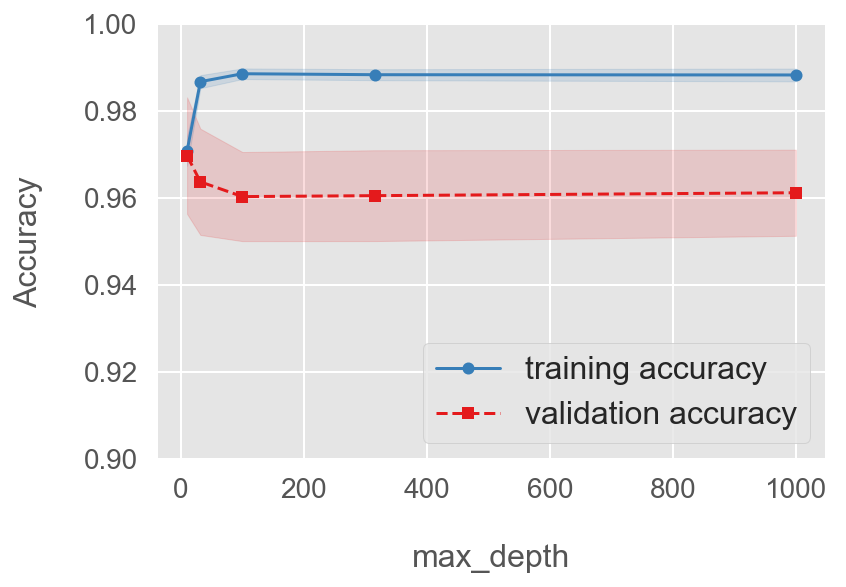

In [211]:
plot_validation_curve(train_scores, test_scores,
                      max_depths, xlabel='max_depth');

In [212]:
%%time

X = df_training[features].values
y = df_training[target].values

clf = RandomForestClassifier(n_estimators=50)
max_depths = np.linspace(1, 30, 5)

train_scores, test_scores = validation_curve(
            estimator=clf,
            X=X,
            y=y,
            param_name='max_depth',
            param_range=max_depths,
            cv=5,
            verbose=10,
            scoring='f1',
);


[CV] max_depth=1.0 ...................................................
[CV] .......... max_depth=1.0, score=0.8492881688757977, total=  24.0s
[CV] max_depth=8.25 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.5s remaining:    0.0s


[CV] ......... max_depth=8.25, score=0.9914163090128756, total= 1.1min
[CV] max_depth=15.5 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] ......... max_depth=15.5, score=0.9907665879321451, total= 1.7min
[CV] max_depth=22.75 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.5min remaining:    0.0s


[CV] ........ max_depth=22.75, score=0.9905498281786942, total= 2.2min
[CV] max_depth=30.0 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.8min remaining:    0.0s


[CV] ......... max_depth=30.0, score=0.9846619140203068, total= 2.7min
[CV] max_depth=1.0 ...................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.6min remaining:    0.0s


[CV] .......... max_depth=1.0, score=0.9148164929768917, total=  21.5s
[CV] max_depth=8.25 ..................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.0min remaining:    0.0s


[CV] ......... max_depth=8.25, score=0.9781455548482919, total= 1.1min
[CV] max_depth=15.5 ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 10.2min remaining:    0.0s


[CV] ......... max_depth=15.5, score=0.9781455548482919, total= 1.8min
[CV] max_depth=22.75 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.0min remaining:    0.0s


[CV] ........ max_depth=22.75, score=0.9777117384843981, total= 2.4min
[CV] max_depth=30.0 ..................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.6min remaining:    0.0s


[CV] .......... max_depth=30.0, score=0.976190476190476, total= 2.8min
[CV] max_depth=1.0 ...................................................
[CV] .......... max_depth=1.0, score=0.9471225313229985, total=  21.4s
[CV] max_depth=8.25 ..................................................
[CV] ......... max_depth=8.25, score=0.9632567849686848, total= 1.1min
[CV] max_depth=15.5 ..................................................
[CV] ......... max_depth=15.5, score=0.9621734587251828, total= 1.8min
[CV] max_depth=22.75 .................................................
[CV] ........ max_depth=22.75, score=0.9626070607896386, total= 2.3min
[CV] max_depth=30.0 ..................................................
[CV] ......... max_depth=30.0, score=0.9615223755750731, total= 2.8min
[CV] max_depth=1.0 ...................................................
[CV] .......... max_depth=1.0, score=0.9538655993258901, total=  20.4s
[CV] max_depth=8.25 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 43.6min finished


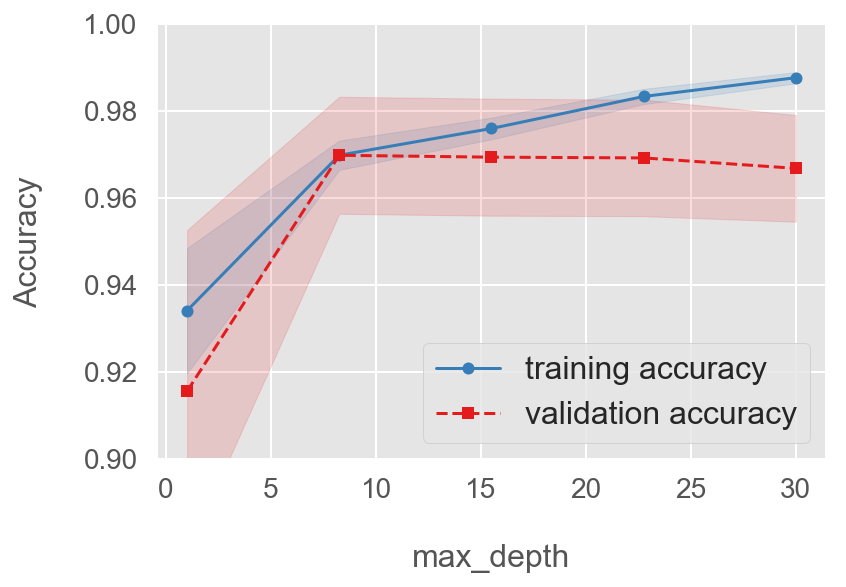

In [213]:
plot_validation_curve(
    train_scores, test_scores,
    max_depths, xlabel='max_depth'
);

It looks like max depth of 10 is good.

I'm not looking to do a deep dive into model selection or parameter tuning. I am more interested in training a model with good bias variance tradeoff and looking at the feature importances.

In [262]:
%%time

X = df_training[features].sample(frac=1).values
y = df_training[target].sample(frac=1).values

clf = RandomForestClassifier(max_depth=10, n_estimators=100)
clf.fit(X, y)

CPU times: user 2min 11s, sys: 9.37 s, total: 2min 20s
Wall time: 2min 4s


In [263]:
from sklearn.metrics import accuracy_score, f1_score, classification_report 

In [264]:
y_hat = clf.predict(X)

In [265]:
print(classification_report(y, y_hat))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    892101
          1       1.00      0.00      0.00     11552

avg / total       0.99      0.99      0.98    903653



Support just lists the value counts.

In [266]:
np.unique(y, return_counts=True)[1]

array([892101,  11552])

I do not understand why there are multiple f1-scores. Also, how can precision be so high while recall is zero?

In [248]:
f1_score?

In [267]:
f1_score(y, y_hat)

0.00017311520817103783


    ``'binary'``:
        Only report results for the class specified by ``pos_label``.
        This is applicable only if targets (``y_{true,pred}``) are binary.
    ``'micro'``:
        Calculate metrics globally by counting the total true positives,
        false negatives and false positives.
    ``'macro'``:
        Calculate metrics for each label, and find their unweighted
        mean.  This does not take label imbalance into account.
    ``'weighted'``:
        Calculate metrics for each label, and find their average, weighted
        by support (the number of true instances for each label). This
        alters 'macro' to account for label imbalance; it can result in an
        F-score that is not between precision and recall.
    ``'samples'``:
        Calculate metrics for each instance, and find their average (only
        meaningful for multilabel classification where this differs from
        :func:`accuracy_score`).


In [268]:
f1_score(y, y_hat, average='binary', pos_label=0)

0.9935676008894319

In [269]:
f1_score(y, y_hat, average='binary', pos_label=1)

0.00017311520817103783

In [270]:
f1_score(y, y_hat, average='micro')

0.9872174385521876

In [271]:
f1_score(y, y_hat, average='macro')

0.4968703580488015

In [272]:
f1_score(y, y_hat, average='weighted')

0.9808683755246183

I think recall is zero because no class was given a label of 1. Let's check the confusion matrix for class probabilities

In [231]:
from sklearn.metrics import confusion_matrix

In [235]:
y.shape

(903653,)

In [234]:
confusion_matrix(y, y_hat)

array([[892101,      0],
       [ 11548,      4]])

In [241]:
cmat = confusion_matrix(y, y_hat)
cmat.diagonal() / cmat.sum(axis=1) * 100

array([1.00000000e+02, 3.46260388e-02])

This is brutal. We only predicted 4/11548 right for the class of interest.

I want to do the hyperparameter tuning with a better f-score metric. Trying to explitily tell it to use `binary`. I think it's doing weighted by default.

AH! The problem before was that I didn't shuffle the samples around.

In [260]:
make_scorer?

In [286]:
%%time

X = df_training[features].sample(frac=1).values
y = df_training[target].sample(frac=1).values


f1_binary_scorer = make_scorer(f1_score, average='binary', pos_label=1)

clf_ = RandomForestClassifier(n_estimators=50)
max_depths = np.linspace(1, 30, 5)

train_scores, test_scores = validation_curve(
            estimator=clf_,
            X=X,
            y=y,
            param_name='max_depth',
            param_range=max_depths,
            cv=5,
            verbose=10,
            scoring=f1_binary_scorer,
);

[CV] max_depth=1.0 ...................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  24.2s
[CV] max_depth=8.25 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.0s remaining:    0.0s
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] ........................ max_depth=8.25, score=0.0, total= 1.3min
[CV] max_depth=15.5 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=15.5, score=0.0, total= 2.4min
[CV] max_depth=22.75 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....................... max_depth=22.75, score=0.0, total= 3.0min
[CV] max_depth=30.0 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.5min remaining:    0.0s


[CV] ........................ max_depth=30.0, score=0.0, total= 4.1min
[CV] max_depth=1.0 ...................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 11.8min remaining:    0.0s
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  23.4s
[CV] max_depth=8.25 ..................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 12.2min remaining:    0.0s
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=8.25, score=0.0, total= 1.3min
[CV] max_depth=15.5 ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 13.6min remaining:    0.0s
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=15.5, score=0.0, total= 2.4min
[CV] max_depth=22.75 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 16.2min remaining:    0.0s


[CV] ....................... max_depth=22.75, score=0.0, total= 3.7min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 20.1min remaining:    0.0s


[CV] max_depth=30.0 ..................................................
[CV] ........................ max_depth=30.0, score=0.0, total= 4.9min
[CV] max_depth=1.0 ...................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  24.8s
[CV] max_depth=8.25 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=8.25, score=0.0, total= 1.5min
[CV] max_depth=15.5 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=15.5, score=0.0, total= 2.4min


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] max_depth=22.75 .................................................
[CV] ....................... max_depth=22.75, score=0.0, total= 3.3min
[CV] max_depth=30.0 ..................................................
[CV] ...... max_depth=30.0, score=0.0008646779074794639, total= 4.9min
[CV] max_depth=1.0 ...................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  29.5s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] max_depth=8.25 ..................................................
[CV] ........................ max_depth=8.25, score=0.0, total= 2.1min
[CV] max_depth=15.5 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=15.5, score=0.0, total= 3.0min
[CV] max_depth=22.75 .................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ....................... max_depth=22.75, score=0.0, total= 4.0min
[CV] max_depth=30.0 ..................................................
[CV] ........................ max_depth=30.0, score=0.0, total= 4.9min
[CV] max_depth=1.0 ...................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  23.4s
[CV] max_depth=8.25 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=8.25, score=0.0, total= 1.4min
[CV] max_depth=15.5 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=15.5, score=0.0, total= 2.4min
[CV] max_depth=22.75 .................................................
[CV] ....................... max_depth=22.75, score=0.0, total= 3.5min
[CV] max_depth=30.0 ..................................................
[CV] ........................ max_depth=30.0, score=0.0, total= 3.7min
CPU times: user 1h 4min 40s, sys: 3min 24s, total: 1h 8min 5s
Wall time: 1h 5min 43s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 65.6min finished


In [288]:
train_scores

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.00539607, 0.00604164, 0.00539549, 0.0064711 , 0.0064711 ],
       [0.02394953, 0.02331551, 0.0237357 , 0.02352438, 0.02984438],
       [0.0512442 , 0.05000527, 0.05247076, 0.04959375, 0.05656608]])

In [289]:
test_scores

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00086468, 0.        , 0.        ]])

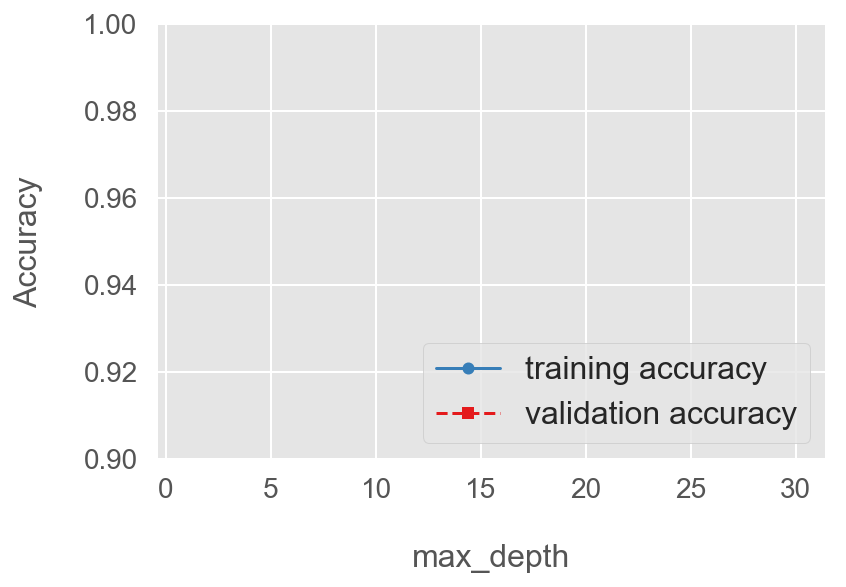

In [287]:
plot_validation_curve(
    train_scores, test_scores,
    max_depths, xlabel='max_depth'
);

Let's try using a custom scorer so we know exactly what should be happening

In [279]:
def custom_score(y_true, y_pred):
    """
    Return the accuracy for class 1.
    """
    m = y_true == 1
    return y_pred[m].sum() / m.sum()

custom_scorer = make_scorer(custom_score)

In [281]:
%%time

X = df_training[features].sample(frac=0.1).values
y = df_training[target].sample(frac=0.1).values

clf = RandomForestClassifier(max_depth=10, n_estimators=10)
clf.fit(X, y)

CPU times: user 2.69 s, sys: 3.52 s, total: 6.21 s
Wall time: 8.04 s


In [283]:
custom_score(y, clf.predict(X))

0.004359197907585004

In [285]:
%%time

X = df_training[features].sample(frac=1).values
y = df_training[target].sample(frac=1).values

clf_ = RandomForestClassifier(n_estimators=10)
max_depths = np.linspace(1, 30, 5)

train_scores, test_scores = validation_curve(
            estimator=clf_,
            X=X,
            y=y,
            param_name='max_depth',
            param_range=max_depths,
            cv=5,
            verbose=10,
            scoring=custom_scorer,
);


[CV] max_depth=1.0 ...................................................
[CV] ......................... max_depth=1.0, score=0.0, total=  13.1s
[CV] max_depth=8.25 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV] ........................ max_depth=8.25, score=0.0, total=  22.4s
[CV] max_depth=15.5 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.8s remaining:    0.0s


[CV] ........................ max_depth=15.5, score=0.0, total=  31.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV] max_depth=22.75 .................................................
[CV] ....................... max_depth=22.75, score=0.0, total=  40.8s
[CV] max_depth=30.0 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


[CV] ..... max_depth=30.0, score=0.00043271311120726956, total= 1.2min
[CV] max_depth=1.0 ...................................................

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min remaining:    0.0s



[CV] ......................... max_depth=1.0, score=0.0, total=  14.8s
[CV] max_depth=8.25 ..................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.4min remaining:    0.0s


[CV] ........................ max_depth=8.25, score=0.0, total=  34.3s
[CV] max_depth=15.5 ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.0min remaining:    0.0s


[CV] ........................ max_depth=15.5, score=0.0, total=  37.2s
[CV] max_depth=22.75 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.7min remaining:    0.0s


[CV] ....................... max_depth=22.75, score=0.0, total=  45.5s
[CV] max_depth=30.0 ..................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.5min remaining:    0.0s


[CV] ........................ max_depth=30.0, score=0.0, total=  57.7s
[CV] max_depth=1.0 ...................................................
[CV] ......................... max_depth=1.0, score=0.0, total=  20.1s
[CV] max_depth=8.25 ..................................................
[CV] ........................ max_depth=8.25, score=0.0, total=  30.1s
[CV] max_depth=15.5 ..................................................
[CV] ........................ max_depth=15.5, score=0.0, total=  35.1s
[CV] max_depth=22.75 .................................................
[CV] ....................... max_depth=22.75, score=0.0, total=  48.8s
[CV] max_depth=30.0 ..................................................
[CV] ........................ max_depth=30.0, score=0.0, total=  58.4s
[CV] max_depth=1.0 ...................................................
[CV] ......................... max_depth=1.0, score=0.0, total=  15.0s
[CV] max_depth=8.25 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 16.2min finished


Since all I care about is finding patterns for converting segments, let's remove any sequences that do not exist for converting segments.

It will also be interesting to look at the paths that get removed, along with their frequency 

In [302]:
print('Make sure that only page path hashes are below...')
print(df_training[features].columns)

Make sure that only page path hashes are below...
Index(['8f4f0025fb85213867ead12d84ea2e5055c357f971f9c8e7f1adb756',
       '60a83762c35819646db68cf17badede7a3aad8ef7aee74e92601e59f',
       '8da84501af62cb70f8ec1ef98f6f97fd350ed51b8d546561081af9fa',
       '2000276390f3a9f47fab5d4125e23af8fde0ff61ec08dee32329174e',
       '7a23cd532f76e62ea1680c6ce9d39a66ddae1135c4ed410f00d33370',
       '11758686905a8d29d8675c2e4415a9442305bceb4801eb6dbe302913',
       '2558b3124736f52244e4f2dc925c5193b6f9a729b4c39b9775cee6b6',
       '3da3de095652c74e2ba50f29a3210b7fccc1b282928ed535176cf621',
       '190d1a56703a1f86bfb124ef74e3a107fa878c751a442e92fdd42c1a',
       '80c7edf12f2dc479b9132db75a9cff27bf8ed017460ffae3cc7ae4a3',
       ...
       '5002d08d178d4bafd0a76eae01e2cf35680dfef666f3647040f7bd41',
       'ede7daaa6e0383b96c3beb451146ada320b401968e3e3eca06a65aad',
       'd35a77b88f394037d30c14f262c4fe720fa445c5d12eb449e00e9f59',
       '379b9dae4488d6313b80f63dd4fdd3665d70839fd28f840b8ca62bd5',
 

In [303]:
m = df_training.transactions > 0
# todo remove head()
s = df_training[m][features].sum()
page_path_hash_non_converting = s[s == 0].index.tolist()

In [304]:
page_path_hash_non_converting = list(page_path_hash_non_converting)

Index([], dtype='object')

OK so there are no patterns that are unique to non-converters. Let's again try out our decision tree parameter search - this time over a wider range of max depth options.

In [306]:
# Function to draw the validation curve

def plot_validation_curve(train_scores, test_scores,
                          param_range, xlabel='', log=False):
    '''
    This code is from scikit-learn docs:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    
    Also here:
    https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch06/ch06.ipynb
    '''
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    
    plt.plot(param_range, train_mean, 
             color=sns.color_palette('Set1')[1], marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color=sns.color_palette('Set1')[1])

    plt.plot(param_range, test_mean, 
             color=sns.color_palette('Set1')[0], linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color=sns.color_palette('Set1')[0])

    if log:
        plt.xscale('log')
    plt.legend(loc='lower right')
    if xlabel:
        plt.xlabel(xlabel)
    plt.ylabel('Score')
#     plt.ylim(0.9, 1.0)
    return fig


In [ ]:
%%time

X = df_training[features].sample(frac=1).values
y = df_training[target].sample(frac=1).values

clf_ = RandomForestClassifier(n_estimators=100)
max_depths = np.linspace(1, 100, 10)

train_scores, test_scores = validation_curve(
            estimator=clf_,
            X=X,
            y=y,
            param_name='max_depth',
            param_range=max_depths,
            cv=5,
            verbose=10,
            scoring=make_scorer(f1_score, average='binary', pos_label=1),
);

[CV] max_depth=1.0 ...................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.8s remaining:    0.0s


[CV] ......................... max_depth=1.0, score=0.0, total=  38.8s
[CV] max_depth=12.0 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=12.0, score=0.0, total= 3.4min
[CV] max_depth=23.0 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=23.0, score=0.0, total= 6.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.6min remaining:    0.0s


[CV] max_depth=34.0 ..................................................
[CV] ........................ max_depth=34.0, score=0.0, total= 8.3min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 19.2min remaining:    0.0s


[CV] max_depth=45.0 ..................................................
[CV] ........................ max_depth=45.0, score=0.0, total=10.3min
[CV] max_depth=56.0 ..................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.8min remaining:    0.0s


[CV] ........................ max_depth=56.0, score=0.0, total=12.5min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 42.7min remaining:    0.0s


[CV] max_depth=67.0 ..................................................
[CV] ...... max_depth=67.0, score=0.0008547008547008547, total=13.1min
[CV] max_depth=78.0 ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 56.2min remaining:    0.0s


[CV] ...... max_depth=78.0, score=0.0008528784648187633, total=13.2min
[CV] max_depth=89.0 ..................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 69.8min remaining:    0.0s


[CV] ...... max_depth=89.0, score=0.0008514261387824606, total=13.9min
[CV] max_depth=100.0 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 84.1min remaining:    0.0s


[CV] ..... max_depth=100.0, score=0.0008507018290089323, total=13.9min
[CV] max_depth=1.0 ...................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  34.2s
[CV] max_depth=12.0 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=12.0, score=0.0, total= 3.3min
[CV] max_depth=23.0 ..................................................
[CV] ........................ max_depth=23.0, score=0.0, total= 5.8min
[CV] max_depth=34.0 ..................................................
[CV] ........................ max_depth=34.0, score=0.0, total= 8.0min
[CV] max_depth=45.0 ..................................................
[CV] ........................ max_depth=45.0, score=0.0, total=10.3min
[CV] max_depth=56.0 ..................................................
[CV] ........................ max_depth=56.0, score=0.0, total=12.8min
[CV] max_depth=67.0 ..................................................
[CV] ...... max_depth=67.0, score=0.0008583690987124464, total=13.3min
[CV] max_depth=78.0 ..................................................
[CV] ...... max_depth=78.0, score=0.0008565310492505354, total=14.0min
[CV] max_depth=89.0 ..................................................
[CV] .

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  33.1s
[CV] max_depth=12.0 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=12.0, score=0.0, total= 3.2min
[CV] max_depth=23.0 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=23.0, score=0.0, total= 5.6min
[CV] max_depth=34.0 ..................................................
[CV] ........................ max_depth=34.0, score=0.0, total= 7.6min
[CV] max_depth=45.0 ..................................................
[CV] ........................ max_depth=45.0, score=0.0, total= 9.0min
[CV] max_depth=56.0 ..................................................
[CV] ........................ max_depth=56.0, score=0.0, total=10.4min
[CV] max_depth=67.0 ..................................................
[CV] ........................ max_depth=67.0, score=0.0, total=11.5min
[CV] max_depth=78.0 ..................................................
[CV] ........................ max_depth=78.0, score=0.0, total=12.5min
[CV] max_depth=89.0 ..................................................
[CV] ........................ max_depth=89.0, score=0.0, total=13.4min
[CV] max_depth=100.0 .................................................
[CV] .

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  37.9s


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] max_depth=12.0 ..................................................
[CV] ........................ max_depth=12.0, score=0.0, total= 3.7min
[CV] max_depth=23.0 ..................................................
[CV] ........................ max_depth=23.0, score=0.0, total= 6.6min
[CV] max_depth=34.0 ..................................................
[CV] ........................ max_depth=34.0, score=0.0, total= 8.6min
[CV] max_depth=45.0 ..................................................
[CV] ........................ max_depth=45.0, score=0.0, total=10.3min
[CV] max_depth=56.0 ..................................................
[CV] ........................ max_depth=56.0, score=0.0, total=11.0min
[CV] max_depth=67.0 ..................................................
[CV] ........................ max_depth=67.0, score=0.0, total=11.7min
[CV] max_depth=78.0 ..................................................
[CV] ........................ max_depth=78.0, score=0.0, total=12.9min
[CV] m

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ......................... max_depth=1.0, score=0.0, total=  36.4s
[CV] max_depth=12.0 ..................................................


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ........................ max_depth=12.0, score=0.0, total= 3.6min
[CV] max_depth=23.0 ..................................................
[CV] ........................ max_depth=23.0, score=0.0, total= 6.5min
[CV] max_depth=34.0 ..................................................
[CV] ........................ max_depth=34.0, score=0.0, total= 8.4min
[CV] max_depth=45.0 ..................................................
[CV] ........................ max_depth=45.0, score=0.0, total=10.5min
[CV] max_depth=56.0 ..................................................
[CV] ........................ max_depth=56.0, score=0.0, total=12.3min
[CV] max_depth=67.0 ..................................................
[CV] ...... max_depth=67.0, score=0.0008565310492505355, total=13.7min
[CV] max_depth=78.0 ..................................................


In [ ]:
plot_validation_curve(
    train_scores, test_scores,
    max_depths, xlabel='max_depth'
);

### Page sequence trends over time

### Top page transitions

Given a specific page, what's the probability of going to each other page? Where does site exits rank in here.

### TODO

- Add DATA_PATH global variable to Gdrive. Move `interim` files


- Predict purchase intent with decision tree. Look at top features. Feature engineering ideas:
    - Split out into converting and non-converting segments
    - Split out into mobile vs desktop


- See how page sequence trends change over time
- Given a specific page, what's the most common next page(s)?

In [58]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')